In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd
import warnings
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
warnings.filterwarnings('ignore')

def findnearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def clim_anom2(data, basedata):
    if len(data.shape)==3:
        clim=np.zeros((12,basedata.shape[1],basedata.shape[2]))
        anom=np.zeros((data.shape))
        for m in range(0,12):
            clim[m,:,:] = np.nanmean(basedata[m:50*12:12,:,:],axis=0)
        for t in range(1,data.shape[0]+1):
            month = np.mod(t,12)
            if month==0:
                month=12
            anom[t-1,:,:]=data[t-1,:,:]-clim[month-1,:,:]
    return clim,anom


### Defining domain in degrees E/N and depth in m

In [2]:
y1 = -45; y2 = 5
x1 = -75; x2 = 25
z1 = 0; z2 = 300

In [3]:
y1_sw = -35; y2_sw = -15
x1_sw = -60; x2_sw = -30

In [4]:
lons=xr.open_dataset('/g/data/y99/gp9664/access-esm/extracted/ocean_grid/geolon_t.nc')['geolon_t'].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
lats=xr.open_dataset('/g/data/y99/gp9664/access-esm/extracted/ocean_grid/geolat_t.nc')['geolat_t'].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
area=xr.open_dataset('/g/data/y99/gp9664/access-esm/extracted/ocean_grid/area_t.nc')['area_t'].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
ht = xr.open_dataset('/g/data/y99/gp9664/access-esm/extracted/ocean_grid/ht_ocean_grid_ACCESS-ESM1-5.nc')['ht'].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
rhoconst = 1035 # kg/m3

In [5]:
time = np.arange(0,100,1/12)
timey = np.arange(0,100,1)

# Salinity tendency
## Computing total salinity tendency

In [6]:
ref_sim = 'pre-industrial'

In [7]:
var_name='dht' # m
var_name2='salt' # psu

d1=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+ref_sim+'/ocean/'+var_name+'_'+ref_sim[0]+'*.nc'))
d1=d1[:10]
d2=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+ref_sim+'/ocean/'+var_name2+'_'+ref_sim[0]+'*.nc'))
d2=d2[:10]
for f in range(0,len(d1)):
    if f==0:
        dhtC=xr.open_dataset(d1[0])[var_name].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
        saltC=xr.open_dataset(d2[0])[var_name2].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
    else:
        tmp=xr.open_dataset(d1[f])[var_name].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)); 
        dhtC=xr.concat([dhtC,tmp],dim='time')
			
        tmp=xr.open_dataset(d2[f])[var_name2].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)); 
        saltC=xr.concat([saltC,tmp],dim='time')

In [8]:
var_name='time_bounds' # s
var_name2='eta_t' # s

d1=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+ref_sim+'/ocean/'+var_name+'_'+ref_sim+'*.nc'))
d1=[d1[0]]
d2=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+ref_sim+'/ocean/'+var_name2+'_'+ref_sim+'*.nc'))
d2=[d2[0]]
for f in range(0,len(d1)):
	if f==0:
		dtC=xr.open_dataset(d1[0])[var_name]
		etaC=xr.open_dataset(d2[0])[var_name2].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
	else:
		tmp=xr.open_dataset(d1[f])[var_name]
		dtC=xr.concat([dtC,tmp],dim='time')

		tmp=xr.open_dataset(d2[f])[var_name2].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
		etaC=xr.concat([etaC,tmp],dim='time')


In [9]:
dtC = dtC.diff('nv').astype('f4') / 1e9
dtC = dtC.squeeze()

In [10]:
sSALTC = saltC*(1+etaC/ht)

In [11]:
# salinity trend (psu/s)
StC = (saltC - saltC.roll(time=1,roll_coords=False)) / dtC  # T_cell(t+1,:,:,:) - T_cell(t,:,:,:)
StC[0,:,:,:] = np.nan
# psu/year
StC = (StC*60*60*24*365).groupby('time.year').mean('time')


In [12]:
StC_sw = (StC.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw))).mean(['st_ocean','yt_ocean','xt_ocean'])

StC_sw_ref = StC_sw.mean('year')

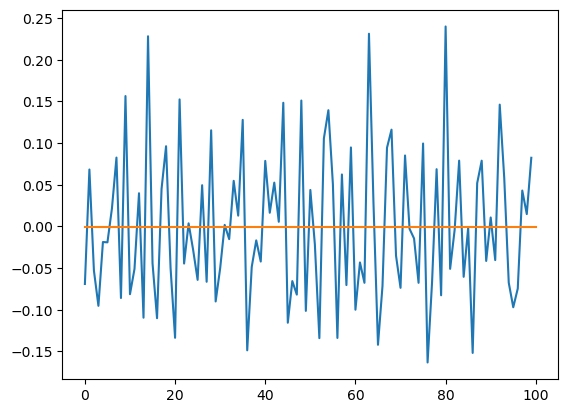

In [13]:
plt.plot(StC_sw)
plt.plot([0,100],[StC_sw.mean('year'),StC_sw.mean('year')])

In [14]:
# plt.plot(StC_sw.cumsum('year'))

# Advection

In [15]:
var_name3='ty_trans' # kg/s
var_name4='tx_trans' # kg/s
var_name5='tz_trans' # kg/s
    
d3=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+ref_sim+'/ocean/'+var_name3+'_'+ref_sim+'*.nc'))
d3=d3[:10]
d4=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+ref_sim+'/ocean/'+var_name4+'_'+ref_sim+'*.nc'))
d4=d4[:10]
d5=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+ref_sim+'/ocean/'+var_name5+'_'+ref_sim+'*.nc'))
d5=d5[:10]
for f in range(0,len(d3)):
    if f==0:
        VC=xr.open_dataset(d3[0])[var_name3].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))/rhoconst
        UC=xr.open_dataset(d4[0])[var_name4].sel(st_ocean=slice(z1,z2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))/rhoconst
        WC=xr.open_dataset(d5[0])[var_name5].sel(sw_ocean=slice(260,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))/rhoconst
    else:
        tmp=xr.open_dataset(d3[f])[var_name3].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))/rhoconst; 
        VC=xr.concat([VC,tmp],dim='time')
			
        tmp=xr.open_dataset(d4[f])[var_name4].sel(st_ocean=slice(z1,z2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))/rhoconst; 
        UC=xr.concat([UC,tmp],dim='time')

        tmp=xr.open_dataset(d5[f])[var_name5].sel(sw_ocean=slice(260,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))/rhoconst; 
        WC=xr.concat([WC,tmp],dim='time')

In [16]:
## psu*m3/s
UsC_sw = UC.sel(yt_ocean=slice(y1_sw,y2_sw),xu_ocean=slice(x2_sw-1,x2_sw))[:,:,:,:-1].values*saltC.sel(yt_ocean=slice(y1_sw,y2_sw),xt_ocean=slice(x2_sw-1,x2_sw)).values
VsC_swn = VC.sel(yu_ocean=slice(y2_sw-1,y2_sw),xt_ocean=slice(x1_sw,x2_sw))[:,:,:,:].values*saltC.sel(yt_ocean=slice(y2_sw-1,y2_sw),xt_ocean=slice(x1_sw,x2_sw)).values
VsC_sws = VC.sel(yu_ocean=slice(y1_sw-1,y1_sw),xt_ocean=slice(x1_sw,x2_sw))[:,:,:,:].values*saltC.sel(yt_ocean=slice(y1_sw-1,y1_sw),xt_ocean=slice(x1_sw,x2_sw)).values
WsC_sw = WC.sel(yt_ocean=slice(y1_sw,y2_sw),xt_ocean=slice(x1_sw,x2_sw))[:,:,:,:].squeeze().values*saltC.sel(yt_ocean=slice(y1_sw,y2_sw),xt_ocean=slice(x1_sw,x2_sw))[:,-1,:,:].values
## psu*m3/year
UsC_sw = np.nanmean(np.nanmean(np.nanmean((UsC_sw),1),1),1)*60*60*24*365
VsC_swn = np.nanmean(np.nanmean(np.nanmean((VsC_swn),1),1),1)*60*60*24*365
VsC_sws = np.nanmean(np.nanmean(np.nanmean((VsC_sws),1),1),1)*60*60*24*365
WsC_sw = np.nanmean(np.nanmean((WsC_sw),1),1)*60*60*24*365

UsC_sw = xr.DataArray(UsC_sw, coords={'time':saltC.time.values},dims=['time'])
VsC_swn = xr.DataArray(VsC_swn, coords={'time':saltC.time.values},dims=['time'])
VsC_sws = xr.DataArray(VsC_sws, coords={'time':saltC.time.values},dims=['time'])
WsC_sw = xr.DataArray(WsC_sw, coords={'time':saltC.time.values},dims=['time'])


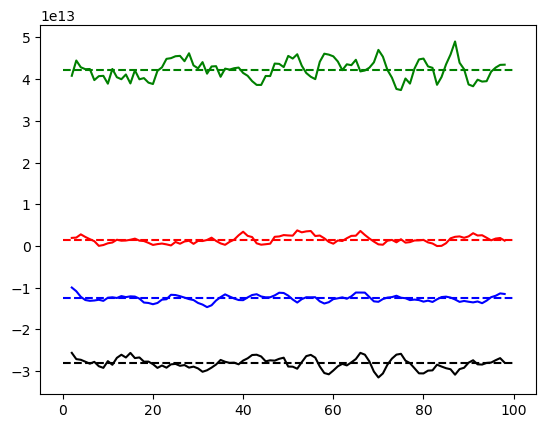

In [17]:
plt.plot(np.arange(2,99,1),movingaverage(UsC_sw.groupby('time.year').mean('time'),4)[2:-1],'k')
plt.plot(np.arange(2,99,1),movingaverage(VsC_sws.groupby('time.year').mean('time'),4)[2:-1],'b')
plt.plot(np.arange(2,99,1),movingaverage(VsC_swn.groupby('time.year').mean('time'),4)[2:-1],'g')
plt.plot(np.arange(2,99,1),movingaverage(WsC_sw.groupby('time.year').mean('time'),4)[2:-1],'r')
plt.plot([0,100],[WsC_sw.mean(['time']),WsC_sw.mean(['time'])],'--r')
plt.plot([0,100],[UsC_sw.mean(['time']),UsC_sw.mean(['time'])],'--k')
plt.plot([0,100],[VsC_sws.mean(['time']),VsC_sws.mean(['time'])],'--b')
plt.plot([0,100],[VsC_swn.mean(['time']),VsC_swn.mean(['time'])],'--g')

In [18]:
rstarfacC = ((ht.sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)) + etaC)/ht.sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)))
volC = dhtC*area.sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
rvolC = rstarfacC*volC
# plt.contourf(vol.xt_ocean,vol.yt_ocean,vol[0,:,:,:].sum(['st_ocean']))
rvolC_sw = rvolC.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).sum(['st_ocean','xt_ocean','yt_ocean'])

In [19]:
# psu/year
divVsC_sw = (VsC_swn - VsC_sws)/rvolC_sw
divUsC_sw = (UsC_sw - 0)/rvolC_sw
divWsC_sw = (WsC_sw - 0)/rvolC_sw
divC_sw = divVsC_sw + divUsC_sw

divVsC_sw = divVsC_sw.groupby('time.year').mean('time')
divUsC_sw = divUsC_sw.groupby('time.year').mean('time')
divWsC_sw = divWsC_sw.groupby('time.year').mean('time')
divC_sw = divC_sw.groupby('time.year').mean('time')

divVsC_sw_ref = divVsC_sw.mean()
divUsC_sw_ref = divUsC_sw.mean()
divWsC_sw_ref = divWsC_sw.mean()
divC_sw_ref = divC_sw.mean()

In [20]:
# plt.plot(np.arange(2,99,1),movingaverage(divUsC_sw.groupby('time.year').mean('time'),4)[2:-1],'k')
# plt.plot(np.arange(2,99,1),movingaverage(divVsC_sw.groupby('time.year').mean('time'),4)[2:-1],'g')
# plt.plot(np.arange(2,99,1),movingaverage(divC_sw.groupby('time.year').mean('time'),4)[2:-1],'b')
# plt.plot(np.arange(2,99,1),movingaverage(divWsC_sw.groupby('time.year').mean('time'),4)[2:-1],'r')

# plt.plot([0,100],[divWsC_sw.mean(['time']),divWsC_sw.mean(['time'])],'--r')
# plt.plot([0,100],[divUsC_sw.mean(['time']),divUsC_sw.mean(['time'])],'--k')
# plt.plot([0,100],[divVsC_sw.mean(['time']),divVsC_sw.mean(['time'])],'--g')
# plt.plot([0,100],[divC_sw.mean(['time']),divC_sw.mean(['time'])],'--b')

# plt.title('Components of salinity advection divergence')
# plt.legend(['Zonal adv div','Meridional adv div','Horizontal adv div','Vertical adv div'])

# Vertical Difussive salinity convergence

In [21]:
var_name3='salt_vdiffuse_impl' # kg/s
d3=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+ref_sim+'/ocean/'+var_name3+'_'+ref_sim+'*.nc'))
d3=d3[:10]
for f in range(0,len(d3)):
    if f==0:
        WdsC=xr.open_dataset(d3[0])[var_name3].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
    else:			
        tmp=xr.open_dataset(d3[f])[var_name3].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time']); 
        WdsC=xr.concat([WdsC,tmp],dim='year')

In [22]:
WdsC.shape

(100, 24, 90, 100)

In [23]:
dhtC_y = dhtC.groupby('time.year').mean('time')
rstarfacC_y = rstarfacC.groupby('time.year').mean('time')
saltC_y = saltC.groupby('time.year').mean('time')

In [24]:
WdsC = (WdsC/rhoconst)/dhtC_y
WdsC = (saltC_y*WdsC)/rstarfacC_y

In [25]:
WdsC_sw = WdsC.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean','st_ocean'])*60*60*24*365

WdsC_sw_ref = WdsC_sw.mean('year')

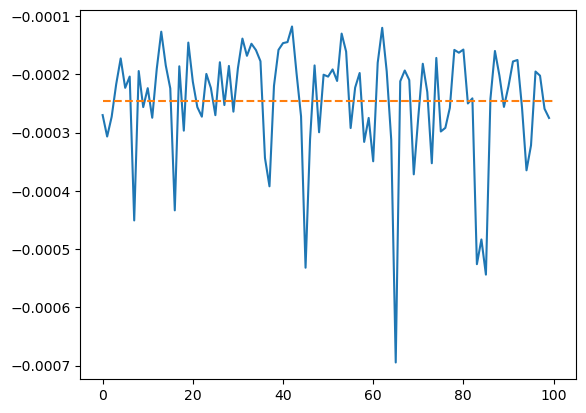

In [26]:
plt.plot(WdsC_sw)
plt.plot([0,100],[WdsC_sw.mean('year'),WdsC_sw.mean('year')],'--')

# Surface fluxes

In [27]:
# var_name3='mixdownslope_salt' # kg/s
# d3=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+ref_sim+'/ocean/'+var_name3+'_'+ref_sim+'*.nc'))
# d3=d3[:10]
# for f in range(0,1):#len(d3)
#     if f==0:
#         saltdownC=xr.open_dataset(d3[0])[var_name3].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
#     else:			
#         tmp=xr.open_dataset(d3[f])[var_name3].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time']); 
#         saltdownC=xr.concat([saltdownC,tmp],dim='year')

In [28]:
# saltdownflxC = forcVrunoffC/1000/rhoconst/area

In [29]:
# saltdownflxC_sw = saltdownflxC.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean','st_ocean'])*60*60*24*365

In [30]:
## pme, melt, runoff --> (kg/m^3)*(m/sec)
var_name='pme_river'
var_name2='evap'
var_name3='lprec'
var_name4='melt'
var_name5='runoff'
var_name6='sfc_salt_flux_runoff'

d1=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+ref_sim+'/ocean/'+var_name+'*.nc'));d1=[d1[0]]
d2=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+ref_sim+'/ocean/'+var_name2+'*.nc'));d2=[d2[0]]
d3=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+ref_sim+'/ocean/'+var_name3+'*.nc'));d3=[d3[0]]
d4=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+ref_sim+'/ocean/'+var_name4+'*.nc'));d4=[d4[0]]
d5=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+ref_sim+'/ocean/'+var_name5+'*.nc'));d5=[d5[0]]
d6=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+ref_sim+'/ocean/'+var_name6+'*.nc'));d6=[d6[0]]
for f in range(0,len(d1)):
    if f==0:
        pmeC=xr.open_dataset(d1[0])[var_name].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
        evapC=xr.open_dataset(d2[0])[var_name2].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
        prC=xr.open_dataset(d3[0])[var_name3].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
        meltC=xr.open_dataset(d4[0])[var_name4].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
        runoffC=xr.open_dataset(d5[0])[var_name5].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
        salt_runoffC=xr.open_dataset(d6[0])[var_name6].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
    else:
        tmp=xr.open_dataset(d1[f])[var_name].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time']); pmeC=xr.concat([pmeC,tmp],dim='year')
        tmp=xr.open_dataset(d2[f])[var_name2].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time']); evapC=xr.concat([evapC,tmp],dim='year')
        tmp=xr.open_dataset(d3[f])[var_name3].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time']); prC=xr.concat([prC,tmp],dim='year')
        tmp4=xr.open_dataset(d4[f])[var_name4].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time']); meltC=xr.concat([meltC,tmp4],dim='year')
        tmp5=xr.open_dataset(d5[f])[var_name5].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time']); runoffC=xr.concat([runoffC,tmp5],dim='year')
        tmp6=xr.open_dataset(d6[f])[var_name6].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time']); salt_runoffC=xr.concat([salt_runoffC,tmp6],dim='year')

In [31]:
pmeC = pmeC.assign_coords(st_ocean=saltC.st_ocean[0].values).expand_dims('st_ocean')
evapC = evapC.assign_coords(st_ocean=saltC.st_ocean[0].values).expand_dims('st_ocean')
prC = prC.assign_coords(st_ocean=saltC.st_ocean[0].values).expand_dims('st_ocean')
meltC = meltC.assign_coords(st_ocean=saltC.st_ocean[0].values).expand_dims('st_ocean')
runoffC = runoffC.assign_coords(st_ocean=saltC.st_ocean[0].values).expand_dims('st_ocean')

forcVpmeC = xr.concat([(pmeC/rhoconst)/dhtC_y,
                   xr.zeros_like((pmeC[0]/rhoconst)/(dhtC_y).isel(st_ocean=slice(1,None)))],
                  dim='st_ocean')
forcVevapC = xr.concat([(evapC/rhoconst)/dhtC_y,
                   xr.zeros_like((evapC[0]/rhoconst)/(dhtC_y).isel(st_ocean=slice(1,None)))],
                  dim='st_ocean')
forcVprC = xr.concat([(prC/rhoconst)/dhtC_y,
                   xr.zeros_like((prC[0]/rhoconst)/(dhtC_y).isel(st_ocean=slice(1,None)))],
                  dim='st_ocean')
forcVmeltC = xr.concat([(meltC/rhoconst)/dhtC_y,
                   xr.zeros_like((meltC[0]/rhoconst)/(dhtC_y).isel(st_ocean=slice(1,None)))],
                  dim='st_ocean')
forcVrunoffC = xr.concat([(runoffC/rhoconst)/dhtC_y,
                   xr.zeros_like((runoffC[0]/rhoconst)/(dhtC_y).isel(st_ocean=slice(1,None)))],
                  dim='st_ocean')

pmeflxC = (-saltC_y*forcVpmeC)/rstarfacC_y
evapflxC = (-saltC_y*forcVevapC)/rstarfacC_y
prflxC = (-saltC_y*forcVprC)/rstarfacC_y
meltflxC = (-saltC_y*forcVmeltC)/rstarfacC_y
runoffflxC = (-saltC_y*forcVrunoffC)/rstarfacC_y

salt_runoffC = salt_runoffC.assign_coords(st_ocean=saltC.st_ocean[0].values).expand_dims('st_ocean')
forcVsalt_runoffC = xr.concat([salt_runoffC/1000,
                   xr.zeros_like((runoffC[0]/rhoconst)/(dhtC_y).isel(st_ocean=slice(1,None)))],
                  dim='st_ocean')
salt_runoffflxC = forcVrunoffC/rhoconst/area

In [32]:
pmeflxC_sw = pmeflxC.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean','st_ocean'])*60*60*24*365
evapflxC_sw = evapflxC.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean','st_ocean'])*60*60*24*365
prflxC_sw = prflxC.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean','st_ocean'])*60*60*24*365
meltflxC_sw = meltflxC.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean','st_ocean'])*60*60*24*365
runoffflxC_sw = runoffflxC.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean','st_ocean'])*60*60*24*365

pmeflxC_sw_ref = pmeflxC_sw.mean('year')
evapflxC_sw_ref = evapflxC_sw.mean('year')
prflxC_sw_ref = prflxC_sw.mean('year')
runoffflxC_sw_ref = runoffflxC_sw.mean('year')
meltflxC_sw_ref = meltflxC_sw.mean('year')

salt_runoffflxC_sw = runoffflxC.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean','st_ocean'])*60*60*24*365
salt_runoffflxC_sw_ref = salt_runoffflxC_sw.mean('year')

In [33]:
# plt.contourf(rstarfacC_y[:,:,-1])
# plt.colorbar()

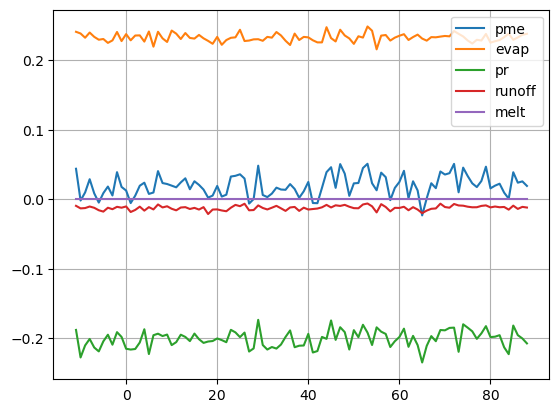

In [34]:
plt.plot(pmeflxC_sw.year-112,(pmeflxC_sw))

plt.plot(pmeflxC_sw.year-112,(evapflxC_sw))

plt.plot(pmeflxC_sw.year-112,(prflxC_sw))

plt.plot(runoffflxC_sw.year-112,(runoffflxC_sw))

plt.plot(meltflxC_sw.year-112,(meltflxC_sw))

# plt.plot(saltdownflxC_sw.year-112,(saltdownflxC_sw),'goldenrod')
# plt.plot(salt_runoffflxC_sw.year-112,(salt_runoffflxC_sw),'goldenrod')
plt.grid()
plt.legend(['pme','evap','pr','runoff','melt'])

# Perturbation run


In [35]:
sim = 'PI-FW04Gr-ic-04'

## Salinity tendency

In [36]:
var_name='dht' # m
var_name2='salt' # psu
var_name3='ty_trans' # kg/s
var_name4='tx_trans' # kg/s
var_name5='tz_trans' # kg/s

d1=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+sim+'/ocean/'+var_name+'_'+sim+'*.nc'))
d1=d1[:10]
d2=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+sim+'/ocean/'+var_name2+'_'+sim+'*.nc'))
d2=d2[:10]
d3=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+sim+'/ocean/'+var_name3+'_'+sim+'*.nc'))
d3=d3[:10]
d4=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+sim+'/ocean/'+var_name4+'_'+sim+'*.nc'))
d4=d4[:10]
d5=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+sim+'/ocean/'+var_name5+'_'+sim+'*.nc'))
d5=d5[:10]
for f in range(0,len(d1)):
    if f==0:
        dht=xr.open_dataset(d1[0])[var_name].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
        salt=xr.open_dataset(d2[0])[var_name2].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
        V=xr.open_dataset(d3[0])[var_name3].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))/rhoconst
        U=xr.open_dataset(d4[0])[var_name4].sel(st_ocean=slice(z1,z2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))/rhoconst
        W=xr.open_dataset(d5[0])[var_name5].sel(sw_ocean=slice(260,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))/rhoconst
    else:
        tmp=xr.open_dataset(d1[f])[var_name].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)); 
        dht=xr.concat([dht,tmp],dim='time')
			
        tmp=xr.open_dataset(d2[f])[var_name2].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)); 
        salt=xr.concat([salt,tmp],dim='time')
			
        tmp=xr.open_dataset(d3[f])[var_name3].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))/rhoconst; 
        V=xr.concat([V,tmp],dim='time')
			
        tmp=xr.open_dataset(d4[f])[var_name4].sel(st_ocean=slice(z1,z2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))/rhoconst; 
        U=xr.concat([U,tmp],dim='time')

        tmp=xr.open_dataset(d5[f])[var_name5].sel(sw_ocean=slice(260,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))/rhoconst; 
        W=xr.concat([W,tmp],dim='time')

In [37]:
var_name='time_bounds' # s
var_name2='eta_t' # m

d1=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+sim+'/ocean/'+var_name+'_'+sim+'*.nc'))
d1=[d1[0]]
d2=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+sim+'/ocean/'+var_name2+'_'+sim+'*.nc'))
d2=[d2[0]]
for f in range(0,len(d1)):
	if f==0:
		dt=xr.open_dataset(d1[0])[var_name]
		eta=xr.open_dataset(d2[0])[var_name2].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
	else:
		tmp=xr.open_dataset(d1[f])[var_name]
		dt=xr.concat([dt,tmp],dim='time')

		tmp=xr.open_dataset(d2[f])[var_name2].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
		eta=xr.concat([eta,tmp],dim='time')


In [38]:
dt = dt.diff('nv').astype('f4') / 1e9
dt = dt.squeeze()

In [39]:
sSALT = salt*(1+eta/ht)

In [40]:
# salinity trend (psu/s)
St = (salt - salt.roll(time=1,roll_coords=False)) / dt  # T_cell(t+1,:,:,:) - T_cell(t,:,:,:)
St[0,:,:,:] = np.nan
# psu/year
St = (St*60*60*24*365).groupby('time.year').mean('time')

In [41]:
# plt.plot(St_sw)
# plt.plot(St_se)

In [42]:
# plt.plot(St_sw.cumsum('year'))
# plt.plot(St_se.cumsum('year'))

In [43]:
St_intt = St.mean(['st_ocean']).cumsum('year')

In [44]:
St_intt[np.where(St_intt)==0] = np.nan

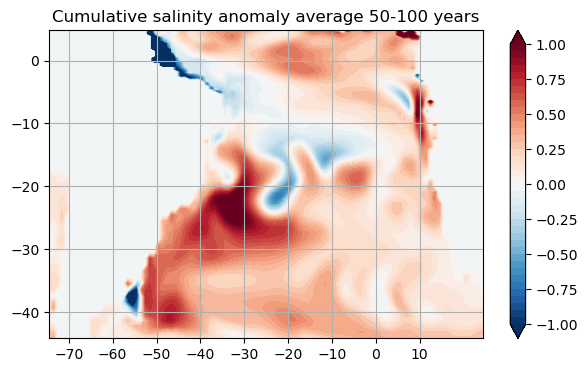

In [45]:
fig=plt.figure(4,figsize=(7,4))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# ax.set_xticks(np.arange(-90,41,20), crs=ccrs.PlateCarree())
# ax.set_yticks(np.arange(-40,10,10), crs=ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND,color='grey')
# ax.set_extent([-70, 25, -45, 5], crs=ccrs.PlateCarree())
a=plt.contourf(lons,lats,St_intt[-50:,:,:].mean('year'),
             np.arange(-1,1.01,0.05),
             #np.arange(-2e-5,2.01e-5,0.5e-6),
             #np.arange(-2e-15,2.01e-15,0.5e-16),
        	#transform=ccrs.PlateCarree(),
               cmap='RdBu_r',extend='both')
plt.title('Cumulative salinity anomaly average 50-100 years')
# cax1 = fig.add_axes([ 0.365, 0.045, 0.28, 0.02 ])
# cbar1=fig.colorbar(a,cax1,ticks=np.arange(-1.5e10,1.51e10,0.5e10),
# 	label='',orientation='horizontal',ticklocation='bottom')
plt.colorbar()
plt.xticks(np.arange(-70,20,10))
plt.grid()

In [46]:
St_sw = (St.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw))).mean(['st_ocean','yt_ocean','xt_ocean']) - StC_sw_ref
# St_se = (St.sel(xt_ocean=slice(5,20),yt_ocean=slice(-30,0))).mean(['st_ocean','yt_ocean','xt_ocean'])

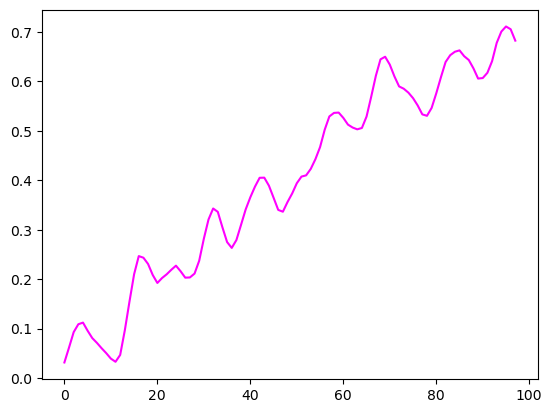

In [47]:
plt.plot(St_sw.year[:-2]-St_sw.year[0],movingaverage(movingaverage(St_sw.cumsum('year'),4),4)[:-2],'magenta')
# plt.plot(St_sw.year[2:-2]-112,movingaverage(movingaverage(St_se.cumsum('year'),4),4)[2:-2],'green')


## Advective salinity convergence
Use Ty_trans, tx_trans and salt

In [48]:
rstarfac = ((ht.sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)) + eta)/ht.sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)))
vol = dht*area.sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
rvol = rstarfac*vol
# plt.contourf(vol.xt_ocean,vol.yt_ocean,vol[0,:,:,:].sum(['st_ocean']))

In [49]:
rvol_sw = rvol.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).sum(['st_ocean','xt_ocean','yt_ocean'])

In [50]:
## psu*m3/s
Us_sw = U.sel(yt_ocean=slice(y1_sw,y2_sw),xu_ocean=slice(x2_sw-1,x2_sw))[:,:,:,:-1].values*salt.sel(yt_ocean=slice(y1_sw,y2_sw),xt_ocean=slice(x2_sw-1,x2_sw)).values
Vs_swn = V.sel(yu_ocean=slice(y2_sw-1,y2_sw),xt_ocean=slice(x1_sw,x2_sw))[:,:,:,:].values*salt.sel(yt_ocean=slice(y2_sw-1,y2_sw),xt_ocean=slice(x1_sw,x2_sw)).values
Vs_sws = V.sel(yu_ocean=slice(y1_sw-1,y1_sw),xt_ocean=slice(x1_sw,x2_sw))[:,:,:,:].values*salt.sel(yt_ocean=slice(y1_sw-1,y1_sw),xt_ocean=slice(x1_sw,x2_sw)).values
Ws_sw = W.sel(yt_ocean=slice(y1_sw,y2_sw),xt_ocean=slice(x1_sw,x2_sw))[:,:,:,:].squeeze().values*salt.sel(yt_ocean=slice(y1_sw,y2_sw),xt_ocean=slice(x1_sw,x2_sw))[:,-1,:,:].values
## psu*m3/year
Us_sw = np.nanmean(np.nanmean(np.nanmean((Us_sw),1),1),1)*60*60*24*365
Vs_swn = np.nanmean(np.nanmean(np.nanmean((Vs_swn),1),1),1)*60*60*24*365
Vs_sws = np.nanmean(np.nanmean(np.nanmean((Vs_sws),1),1),1)*60*60*24*365
Ws_sw = np.nanmean(np.nanmean((Ws_sw),1),1)*60*60*24*365

Us_sw = xr.DataArray(Us_sw, coords={'time':salt.time.values},dims=['time'])
Vs_swn = xr.DataArray(Vs_swn, coords={'time':salt.time.values},dims=['time'])
Vs_sws = xr.DataArray(Vs_sws, coords={'time':salt.time.values},dims=['time'])
Ws_sw = xr.DataArray(Ws_sw, coords={'time':salt.time.values},dims=['time'])


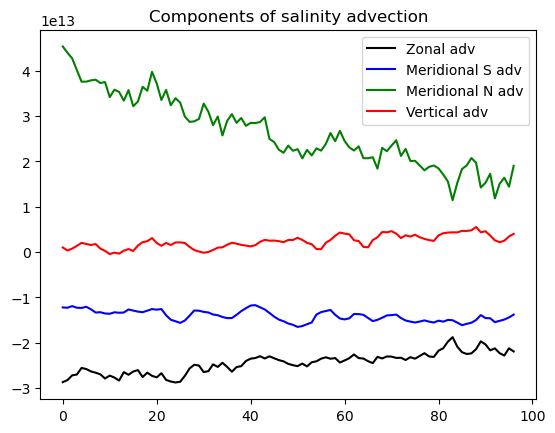

In [51]:
plt.plot(movingaverage(Us_sw.groupby('time.year').mean('time'),4)[2:-1],'k')
plt.plot(movingaverage(Vs_sws.groupby('time.year').mean('time'),4)[2:-1],'b')
plt.plot(movingaverage(Vs_swn.groupby('time.year').mean('time'),4)[2:-1],'g')
plt.plot(movingaverage(Ws_sw.groupby('time.year').mean('time'),4)[2:-1],'r')
plt.title('Components of salinity advection')
plt.legend(['Zonal adv','Meridional S adv','Meridional N adv','Vertical adv'])

In [52]:
# psu/year
divVs_sw = (Vs_swn - Vs_sws)/rvol_sw
divUs_sw = (Us_sw - 0)/rvol_sw
divWs_sw = (Ws_sw - 0)/rvol_sw
div_sw = divVs_sw + divUs_sw

divVs_sw = divVs_sw.groupby('time.year').mean('time') - divVsC_sw_ref
divUs_sw = divUs_sw.groupby('time.year').mean('time') - divUsC_sw_ref
divWs_sw = divWs_sw.groupby('time.year').mean('time') - divWsC_sw_ref
div_sw = div_sw.groupby('time.year').mean('time') - divC_sw_ref

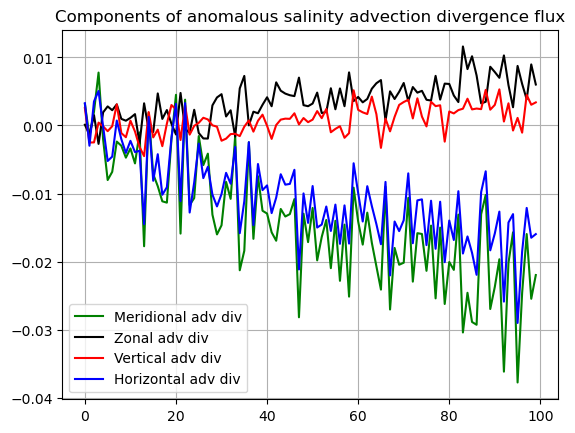

In [53]:
plt.plot(divVs_sw,'g')
plt.plot(divUs_sw,'k')
plt.plot(divWs_sw,'r')
plt.plot(div_sw,'b')
plt.grid()
plt.title('Components of anomalous salinity advection divergence flux')
plt.legend(['Meridional adv div','Zonal adv div','Vertical adv div','Horizontal adv div'])

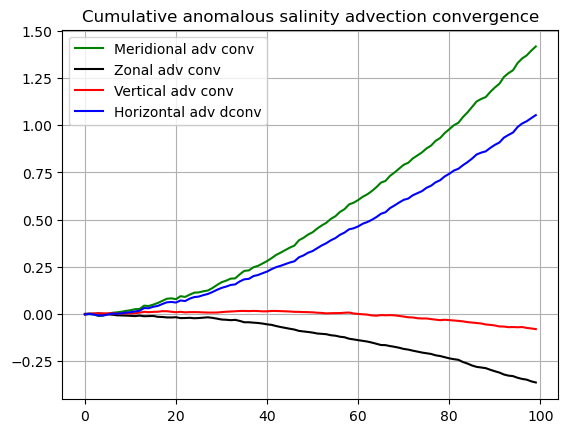

In [54]:
plt.plot(-divVs_sw.cumsum('year'),'g')
plt.plot(-divUs_sw.cumsum('year'),'k')
plt.plot(-divWs_sw.cumsum('year'),'r')
plt.plot(-div_sw.cumsum('year'),'b')
plt.grid()
plt.title('Cumulative anomalous salinity advection convergence')
plt.legend(['Meridional adv conv','Zonal adv conv','Vertical adv conv','Horizontal adv dconv'])

Text(0.5, 1.0, 'Acumulated salinity Anomaly - SW South Atlantic')

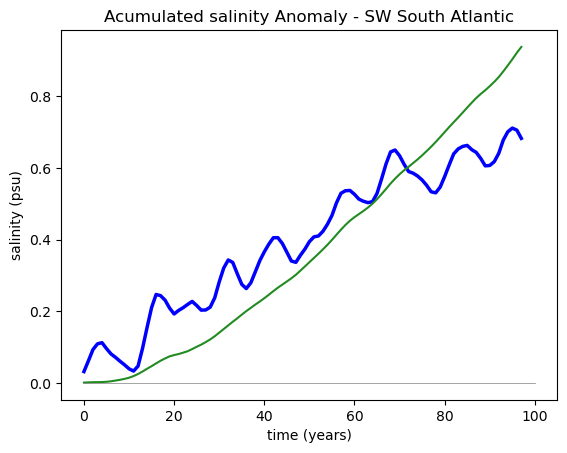

In [55]:
plt.plot(St_sw.year[:-2]-St_sw.year[0],movingaverage(movingaverage(St_sw.cumsum('year'),4),4)[:-2],'b',linewidth = 2.5)

plt.plot(St_sw.year[:-2]-St_sw.year[0],movingaverage(movingaverage(-((div_sw.cumsum('year')-div_sw.cumsum('year')[0])+(divWs_sw.cumsum('year')-divWs_sw.cumsum('year')[0])),4),4)[:-2],
         'forestgreen',linewidth = 1.5)

#plt.plot(St_sw.year[2:-2]-112,movingaverage(movingaverage(-(divWs_sw.cumsum('year')-divWs_sw.cumsum('year')[0]),4),4)[2:-2],'r',linewidth = 1.5)

plt.plot([0,100],[0,0],color='grey',linewidth = 0.5)
# plt.xlim(0,100)
# plt.ylim(-0.6,2)

plt.xlabel('time (years)')
plt.ylabel('salinity (psu)')


# plt.grid()
plt.title('Acumulated salinity Anomaly - SW South Atlantic')
#plt.legend(['Salinity tendency','Horizontal adv convergence','Vertical adv convergence', 'Horizontal diffusive convergence \n (residual)',
#'Vertical diffusive convergence','Surface fluxes','Precipitation','Evaporation','River runoff']) #'Horizontal eddy convergence',

## Vertical difussive salinity convergence

In [56]:
var_name3='salt_vdiffuse_impl' # kg/s
d3=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+sim+'/ocean/'+var_name3+'_'+sim+'*.nc'))
d3=d3[:10]
for f in range(0,len(d3)):
    if f==0:
        Wds=xr.open_dataset(d3[0])[var_name3].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
    else:			
        tmp=xr.open_dataset(d3[f])[var_name3].sel(st_ocean=slice(z1,z2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
        Wds=xr.concat([Wds,tmp],dim='year')

In [57]:
dht_y = dht.groupby('time.year').mean('time')
rstarfac_y = rstarfac.groupby('time.year').mean('time')
salt_y = salt.groupby('time.year').mean('time')

In [58]:
Wds = (Wds/rhoconst)/dht_y
Wds = (salt_y*Wds)/rstarfac_y

In [59]:
Wds_sw = Wds.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean','st_ocean'])*60*60*24*365 - WdsC_sw_ref

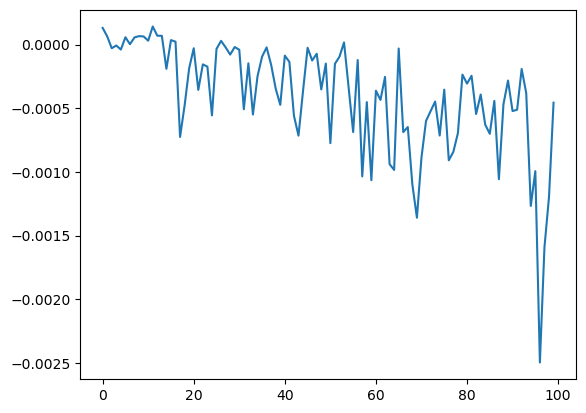

In [60]:
plt.plot(Wds_sw)

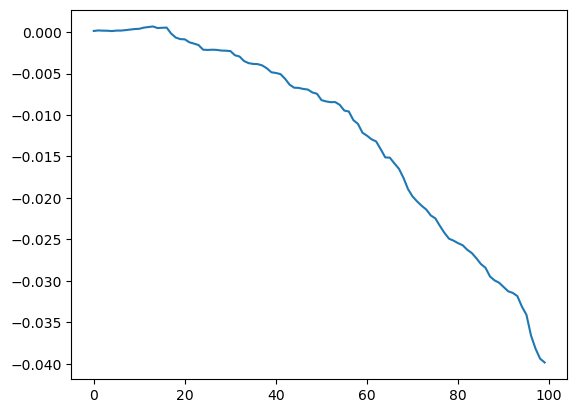

In [61]:
plt.plot(Wds_sw.cumsum('year'))

## Surface Forcing
Net surface freshwater flux into the ocean (P-E).
Freshwater entering the ocean due sea-ice melt/form (melt).
Freshwater entering the ocean via runoff (runoff).

In [62]:
## pme, melt, runoff --> (kg/m^3)*(m/sec)
var_name='pme_river'
var_name2='evap'
var_name3='lprec'
# var_name4='melt'
var_name5='runoff'

d1=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+sim+'/ocean/'+var_name+'*.nc'));d1=[d1[0]]
d2=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+sim+'/ocean/'+var_name2+'*.nc'));d2=[d2[0]]
d3=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+sim+'/ocean/'+var_name3+'*.nc'));d3=[d3[0]]
# d4=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+s+'/ocean/'+var_name4+'*.nc'));d4=[d4[0]]
d5=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+sim+'/ocean/'+var_name5+'*.nc'));d5=[d5[0]]
for f in range(0,len(d1)):
    if f==0:
        pme=xr.open_dataset(d1[0])[var_name].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
        evap=xr.open_dataset(d2[0])[var_name2].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
        pr=xr.open_dataset(d3[0])[var_name3].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
        # melt=xr.open_dataset(d4[0])[var_name4].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
        runoff=xr.open_dataset(d5[0])[var_name5].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
    else:
        tmp=xr.open_dataset(d1[f])[var_name].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time']); pme=xr.concat([pme,tmp],dim='year')
        tmp=xr.open_dataset(d2[f])[var_name2].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time']); evap=xr.concat([evap,tmp],dim='year')
        tmp=xr.open_dataset(d3[f])[var_name3].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time']); pr=xr.concat([pr,tmp],dim='year')
        # tmp4=xr.open_dataset(d4[f])[var_name4].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time']); melt=xr.concat([melt,tmp4],dim='year')
        tmp5=xr.open_dataset(d5[f])[var_name5].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time']); runoff=xr.concat([runoff,tmp5],dim='year')

In [63]:
pme = pme.assign_coords(st_ocean=salt.st_ocean[0].values).expand_dims('st_ocean')
evap = evap.assign_coords(st_ocean=salt.st_ocean[0].values).expand_dims('st_ocean')
pr = pr.assign_coords(st_ocean=salt.st_ocean[0].values).expand_dims('st_ocean')
# melt = melt.assign_coords(st_ocean=salt.st_ocean[0].values).expand_dims('st_ocean')
runoff = runoff.assign_coords(st_ocean=salt.st_ocean[0].values).expand_dims('st_ocean')

forcVpme = xr.concat([(pme/rhoconst)/dht_y,
                   xr.zeros_like((pme[0]/rhoconst)/(dht_y).isel(st_ocean=slice(1,None)))],
                  dim='st_ocean')
forcVevap = xr.concat([(evap/rhoconst)/dht_y,
                   xr.zeros_like((evap[0]/rhoconst)/(dht_y).isel(st_ocean=slice(1,None)))],
                  dim='st_ocean')
forcVpr = xr.concat([(pr/rhoconst)/dht_y,
                   xr.zeros_like((pr[0]/rhoconst)/(dht_y).isel(st_ocean=slice(1,None)))],
                  dim='st_ocean')
# forcVmelt = xr.concat([(melt/rhoconst)/dht_y,
#                    xr.zeros_like((melt[0]/rhoconst)/(dht_y).isel(st_ocean=slice(1,None)))],
#                   dim='st_ocean')
forcVrunoff = xr.concat([(runoff/rhoconst)/dht_y,
                   xr.zeros_like((runoff[0]/rhoconst)/(dht_y).isel(st_ocean=slice(1,None)))],
                  dim='st_ocean')

pmeflx = (-salt_y*forcVpme)/rstarfac_y
evapflx = (-salt_y*forcVevap)/rstarfac_y
prflx = (-salt_y*forcVpr)/rstarfac_y
# meltflx = (-salt_y*forcVmelt)/rstarfac_y
runoffflx = (-salt_y*forcVrunoff)/rstarfac_y

In [64]:
pmeflx_sw = pmeflx.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean','st_ocean'])*60*60*24*365 - pmeflxC_sw_ref
evapflx_sw = evapflx.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean','st_ocean'])*60*60*24*365 - evapflxC_sw_ref
prflx_sw = prflx.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean','st_ocean'])*60*60*24*365 - prflxC_sw_ref
# meltflx_sw = meltflx.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean','st_ocean'])*60*60*24*365 - meltflxC_sw_ref
runoffflx_sw = runoffflx.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean','st_ocean'])*60*60*24*365 - runoffflxC_sw_ref

In [65]:
sfc_forc_sw = evapflx_sw + prflx_sw + runoffflx_sw

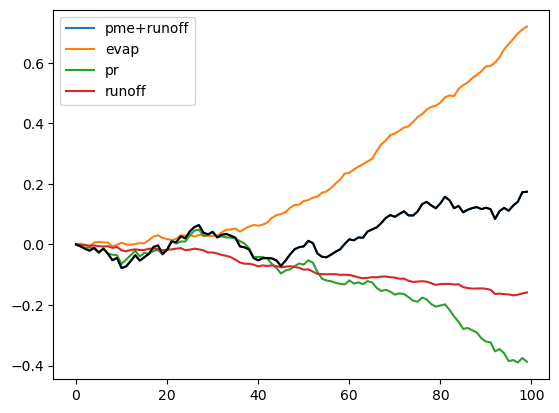

In [66]:
plt.plot(pmeflx_sw.cumsum('year')-pmeflx_sw.cumsum('year')[0])
plt.plot(evapflx_sw.cumsum('year')-evapflx_sw.cumsum('year')[0])
plt.plot(prflx_sw.cumsum('year')-prflx_sw.cumsum('year')[0])
# plt.plot(meltflx_sw.cumsum('year')-meltflx_sw.cumsum('year')[0])
plt.plot(runoffflx_sw.cumsum('year')-runoffflx_sw.cumsum('year')[0])
plt.plot(sfc_forc_sw.cumsum('year')-sfc_forc_sw.cumsum('year')[0],'k')
plt.legend(['pme+runoff','evap','pr','runoff'])

# Salinity budget

Text(0.5, 1.0, 'Cumulative salinity Anomaly - SW South Atlantic')

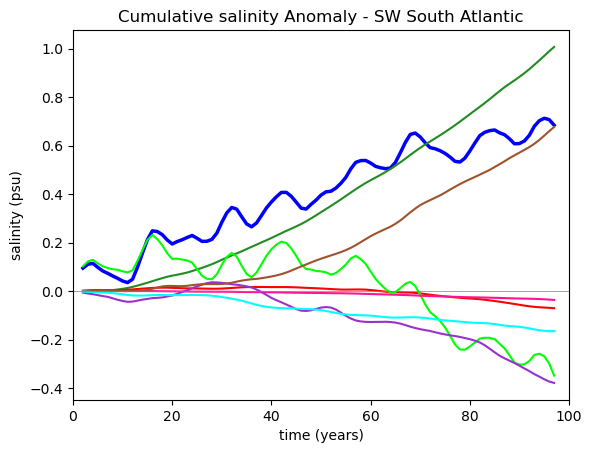

In [67]:
# sfc_forc_sw = sfc_forc_sw - sfc_forc_sw[0]
total = (sfc_forc_sw.cumsum('year'))+(-(div_sw.cumsum('year')-div_sw.cumsum('year')[0]))+(-(divWs_sw.cumsum('year')-divWs_sw.cumsum('year')[0]))+(Wds_sw.cumsum('year')-Wds_sw.cumsum('year')[0])
res = (St_sw.cumsum('year')-St_sw.cumsum('year')[0]) - total

plt.plot(St_sw.year[2:-2]-St_sw.year[0],movingaverage(movingaverage(St_sw.cumsum('year')-St_sw.cumsum('year')[0]+0.02,4),4)[2:-2],'b',linewidth = 2.5)

plt.plot(St_sw.year[2:-2]-St_sw.year[0],movingaverage(movingaverage(-(div_sw.cumsum('year')-div_sw.cumsum('year')[0]),4),4)[2:-2],'forestgreen',linewidth = 1.5)

plt.plot(St_sw.year[2:-2]-St_sw.year[0],movingaverage(movingaverage(-(divWs_sw.cumsum('year')-divWs_sw.cumsum('year')[0]),4),4)[2:-2],'r',linewidth = 1.5)

plt.plot(St_sw.year[2:-2]-St_sw.year[0],movingaverage(movingaverage(res+0.02,4),4)[2:-2],'lime',linewidth = 1.5)

plt.plot(St_sw.year[2:-2]-St_sw.year[0],movingaverage(movingaverage(Wds_sw.cumsum('year'),4),4)[2:-2],'deeppink',linewidth = 1.5)

# plt.plot(St_sw.year[2:-2]-St_sw.year[0],movingaverage(movingaverage((sfc_forc_sw.cumsum('year')-sfc_forc_sw.cumsum('year')[0]),4),4)[2:-2],'gold',linewidth = 1.5)

plt.plot(St_sw.year[2:-2]-St_sw.year[0],movingaverage(movingaverage(prflx_sw.cumsum('year')-prflx_sw.cumsum('year')[0],4),4)[2:-2],'-',color='darkorchid',linewidth = 1.5)

plt.plot(St_sw.year[2:-2]-St_sw.year[0],movingaverage(movingaverage(evapflx_sw.cumsum('year')-evapflx_sw.cumsum('year')[0],4),4)[2:-2],'-',color='sienna',linewidth = 1.5)

plt.plot(St_sw.year[2:-2]-St_sw.year[0],movingaverage(movingaverage(runoffflx_sw.cumsum('year')-runoffflx_sw.cumsum('year')[0],4),4)[2:-2],'-',color='cyan',linewidth = 1.5)

# plt.plot(St_sw.year[2:-2]-112,movingaverage(movingaverage(total,4),4)[2:-2],'k',linewidth = 2.5)

plt.plot([0,100],[0,0],color='grey',linewidth = 0.5)
plt.xlim(0,100)
# plt.ylim(-0.6,2)

plt.xlabel('time (years)')
plt.ylabel('salinity (psu)')

# plt.grid()
plt.title('Cumulative salinity Anomaly - SW South Atlantic')
#plt.legend(['Salinity tendency','Horizontal adv convergence','Vertical adv convergence', 'Horizontal diffusive convergence \n (residual)',
#'Vertical diffusive convergence','Surface fluxes','Precipitation','Evaporation','River runoff']) #'Horizontal eddy convergence',

In [68]:
hor_adv_conv = -(div_sw.cumsum('year')-div_sw.cumsum('year')[0])
vert_adv_conv = -(divWs_sw.cumsum('year')-divWs_sw.cumsum('year')[0])
vert_diff_conv = (Wds_sw.cumsum('year')-Wds_sw.cumsum('year')[0])
hor_diff_conv = res

ocean = (-(div_sw.cumsum('year')-div_sw.cumsum('year')[0]))+(-(divWs_sw.cumsum('year')-divWs_sw.cumsum('year')[0]))+(Wds_sw.cumsum('year')-Wds_sw.cumsum('year')[0])+res

tt = (ocean-ocean[0]/2)+(sfc_forc_sw.cumsum('year')-sfc_forc_sw.cumsum('year')[0])


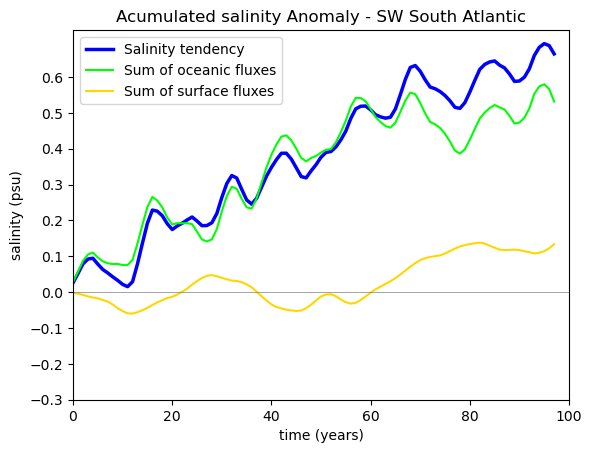

In [69]:
plt.plot(St_sw.year[:-2]-St_sw.year[0],movingaverage(movingaverage(St_sw.cumsum('year')-St_sw.cumsum('year')[0],4),4)[:-2],'b',linewidth = 2.5)

plt.plot(St_sw.year[:-2]-St_sw.year[0],movingaverage(movingaverage(ocean-ocean[0]/2,4),4)[:-2],'lime',linewidth = 1.5)

plt.plot(St_sw.year[:-2]-St_sw.year[0],movingaverage(movingaverage((sfc_forc_sw.cumsum('year')-sfc_forc_sw.cumsum('year')[0]),4),4)[:-2],'gold',linewidth = 1.5)

# plt.plot(St_sw.year[:-2]-St_sw.year[0],movingaverage(movingaverage((pmeflx_sw.cumsum('year')-pmeflx_sw.cumsum('year')[0]),4),4)[:-2],'k',linewidth = 1.5)

plt.plot([0,100],[0,0],color='grey',linewidth = 0.5)
plt.xlim(0,100)
plt.yticks(np.arange(-0.3,0.7,0.1))
# plt.ylim(-0.6,2)

plt.xlabel('time (years)')
plt.ylabel('salinity (psu)')

# plt.grid()
plt.title('Acumulated salinity Anomaly - SW South Atlantic')
plt.legend(['Salinity tendency','Sum of oceanic fluxes','Sum of surface fluxes'])

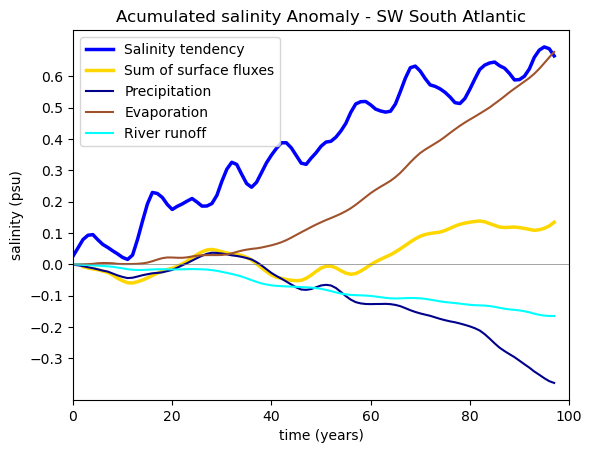

In [70]:
plt.plot(St_sw.year[:-2]-St_sw.year[0],movingaverage(movingaverage(St_sw.cumsum('year')-St_sw.cumsum('year')[0],4),4)[:-2],'b',linewidth = 2.5)

# plt.plot(St_sw.year[:-2]-112,movingaverage(movingaverage(ocean-ocean[0]/2,4),4)[:-2],'lime',linewidth = 1.5)

plt.plot(St_sw.year[2:-2]-St_sw.year[0],movingaverage(movingaverage((sfc_forc_sw.cumsum('year')-sfc_forc_sw.cumsum('year')[0]),4),4)[2:-2],'gold',linewidth = 2.5)

plt.plot(St_sw.year[:-2]-St_sw.year[0],movingaverage(movingaverage(prflx_sw.cumsum('year')-prflx_sw.cumsum('year')[0],4),4)[:-2],'-',color='darkblue',linewidth = 1.5)

plt.plot(St_sw.year[:-2]-St_sw.year[0],movingaverage(movingaverage(evapflx_sw.cumsum('year')-evapflx_sw.cumsum('year')[0],4),4)[:-2],'-',color='sienna',linewidth = 1.5)

plt.plot(St_sw.year[:-2]-St_sw.year[0],movingaverage(movingaverage(runoffflx_sw.cumsum('year')-runoffflx_sw.cumsum('year')[0],4),4)[:-2],'-',color='cyan',linewidth = 1.5)

# plt.plot(St_sw.year[2:-2]-112,movingaverage(movingaverage(total,4),4)[2:-2],'k',linewidth = 2.5)

# plt.plot(St_sw.year[:-2]-112,movingaverage(movingaverage(tt,4),4)[:-2],'k',linewidth = 2.5)

plt.plot([0,100],[0,0],color='grey',linewidth = 0.5)
plt.xlim(0,100)
plt.yticks(np.arange(-0.3,0.7,0.1))
# plt.ylim(-0.6,2)

plt.xlabel('time (years)')
plt.ylabel('salinity (psu)')

# plt.grid()
plt.title('Acumulated salinity Anomaly - SW South Atlantic')
plt.legend(['Salinity tendency','Sum of surface fluxes','Precipitation','Evaporation','River runoff'])#, 'Ocean + Surface'])

# Saving

In [71]:
sim

'PI-FW04Gr-ic-04'

In [72]:
dir_out='/g/data/y99/gp9664/data_AMOC_NGEO/'

sfc_forc_sw = sfc_forc_sw.cumsum('year')-sfc_forc_sw.cumsum('year')[0]
sfc_forc_sw.attrs['long_name']='Cumulative salinity change due to surface fluxes'
sfc_forc_sw.attrs['Units']='psu'
sfc_forc_sw = sfc_forc_sw.to_dataset(name='surf_forc')

pr_sw = prflx_sw.cumsum('year')-prflx_sw.cumsum('year')[0]
pr_sw.attrs['long_name']='Cumulative salinity change due to precipitation fluxes'
pr_sw.attrs['Units']='psu'
pr_sw = pr_sw.to_dataset(name='pr_forc')

evap_sw = evapflx_sw.cumsum('year')-evapflx_sw.cumsum('year')[0]
evap_sw.attrs['long_name']='Cumulative salinity change due to evaporation fluxes'
evap_sw.attrs['Units']='psu'
evap_sw = evap_sw.to_dataset(name='evap_forc')

runoff_sw = runoffflx_sw.cumsum('year')-runoffflx_sw.cumsum('year')[0]
runoff_sw.attrs['long_name']='Cumulative salinity change due to runoff fluxes'
runoff_sw.attrs['Units']='psu'
runoff_sw = runoff_sw.to_dataset(name='runoff_forc')

ocean.attrs['long_name']='Cumulative salinity change due to oceanic fluxes'
ocean.attrs['Units']='psu'
ocean = ocean.to_dataset(name='ocean_conv')

hor_adv_conv.attrs['long_name']='Cumulative salinity change due to horizontal advective convergence'
hor_adv_conv.attrs['Units']='psu'
hor_adv_conv = hor_adv_conv.to_dataset(name='hor_adv_conv')

vert_adv_conv.attrs['long_name']='Cumulative salinity change due to vertical advective convergence'
vert_adv_conv.attrs['Units']='psu'
vert_adv_conv = vert_adv_conv.to_dataset(name='vert_adv_conv')

hor_diff_conv.attrs['long_name']='Cumulative salinity change due to horizontal diffusive convergence'
hor_diff_conv.attrs['Units']='psu'
hor_diff_conv = hor_diff_conv.to_dataset(name='hor_diff_conv')

vert_diff_conv.attrs['long_name']='Cumulative salinity change due to vertical diffusive convergence'
vert_diff_conv.attrs['Units']='psu'
vert_diff_conv = vert_diff_conv.to_dataset(name='vert_diff_conv')

St_sw = St_sw.cumsum('year')-St_sw.cumsum('year')[0]
St_sw.attrs['long_name']='Cumulative salinity tendency'
St_sw.attrs['Units']='psu'
St_sw = St_sw.to_dataset(name='salt_tend')

out = xr.merge([ocean,St_sw,sfc_forc_sw,pr_sw,evap_sw,runoff_sw,hor_adv_conv,vert_adv_conv,hor_diff_conv,vert_diff_conv])
out.attrs['Formula']='Mean fluxes between 35S-15S and 55W-35W'
out.attrs['model']='ACCESS-ESM1.5'
out.attrs['simulation']=sim
out.attrs['reference']='pre-industrial'
out.to_netcdf(dir_out+'FigED2_Salinity_budget_SWSA_'+sim+'.nc','w')


# SST vs Evap

In [147]:
## pme, melt, runoff --> (kg/m^3)*(m/sec)
s='pre-industrial'
var_name='sst'
d1=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+s+'/ocean/'+var_name+'*.nc'));d1=[d1[0]]
for f in range(0,len(d1)):
    if f==0:
        sstC=xr.open_dataset(d1[0])[var_name].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
    else:
        tmp=xr.open_dataset(d1[f])[var_name].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time']); sstC=xr.concat([sstC,tmp],dim='year')

In [148]:
## pme, melt, runoff --> (kg/m^3)*(m/sec)
s='PI-FW04Gr-ic'
var_name='sst'
d1=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+s+'/ocean/'+var_name+'*.nc'));d1=[d1[0]]
for f in range(0,len(d1)):
    if f==0:
        sst=xr.open_dataset(d1[0])[var_name].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time'])
    else:
        tmp=xr.open_dataset(d1[f])[var_name].sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2)).groupby('time.year').mean(['time']); sst=xr.concat([sst,tmp],dim='year')

In [150]:
sstC_sw = sstC.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean'])
sst_sw = sst.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean']).values -sstC_sw.values


In [151]:
evapC_sw = evapC.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean']).squeeze()
evap_sw = evap.sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean']).squeeze().values -evapC_sw.values


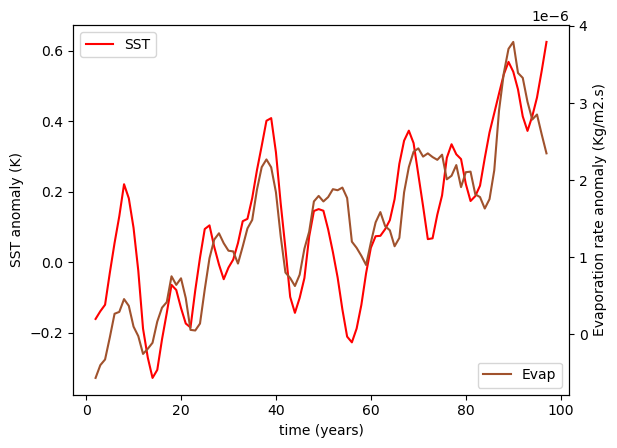

In [152]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

fig, host = plt.subplots()
plt.xlabel("time (years)")
ax2 = host.twinx()

host.set_ylabel("SST anomaly (K)")
ax2.set_ylabel("Evaporation rate anomaly (Kg/m2.s)")

p1, = host.plot(St_sw.year[2:-2]-112,movingaverage(movingaverage(sst_sw,4),4)[2:-2],'r')
host.legend(['SST'],loc=2)

# p2, = ax2.plot(St_sw.year[2:-2]-112,movingaverage(movingaverage(evapflx_sw.cumsum('year')-evapflx_sw.cumsum('year')[0],4),4)[2:-2],'-',color='sienna',linewidth = 1.5)
p2, = ax2.plot(St_sw.year[2:-2]-112,movingaverage(movingaverage(-evap_sw,4),4)[2:-2],'-',color='sienna',linewidth = 1.5)
# ax2.set_ylim(-500,100)
# plt.xticks(np.arange(1900,2080,10))
# plt.xlim(1900-5,2075)
ax2.legend(['Evap'],loc=4)


# host.axis["left"].label.set_color(p1.get_color())
# ax2.axis["right"].label.set_color(p2.get_color())


In [ ]:
##############################   END    ######################################

# Plotting multi-ensemble mean

In [79]:
d1=sorted(glob.glob('/g/data/y99/gp9664/data_AMOC_NGEO/FigED2_Salinity_budget_SWSA*nc'))
for e in range(0,len(d1)):
    if e==0:
        surf = np.expand_dims(xr.open_dataset(d1[0]).surf_forc.values,1)
        pr = np.expand_dims(xr.open_dataset(d1[0]).pr_forc.values,1)
        evap = np.expand_dims(xr.open_dataset(d1[0]).evap_forc.values,1)
        runoff = np.expand_dims(xr.open_dataset(d1[0]).runoff_forc.values,1)
        ocean = np.expand_dims(xr.open_dataset(d1[0]).ocean_conv.values,1)
        st = np.expand_dims(xr.open_dataset(d1[0]).salt_tend.values,1)
        hor_adv_conv = np.expand_dims(xr.open_dataset(d1[0]).hor_adv_conv.values,1)
        hor_diff_conv = np.expand_dims(xr.open_dataset(d1[0]).hor_diff_conv.values,1)
        vert_adv_conv = np.expand_dims(xr.open_dataset(d1[0]).vert_adv_conv.values,1)
        vert_diff_conv = np.expand_dims(xr.open_dataset(d1[0]).vert_diff_conv.values,1)
    else:
        surf = np.concatenate([surf,np.expand_dims(xr.open_dataset(d1[e]).surf_forc.values,1)],axis=1)
        pr = np.concatenate([pr,np.expand_dims(xr.open_dataset(d1[e]).pr_forc.values,1)],axis=1)
        evap = np.concatenate([evap,np.expand_dims(xr.open_dataset(d1[e]).evap_forc.values,1)],axis=1)
        runoff = np.concatenate([runoff,np.expand_dims(xr.open_dataset(d1[e]).runoff_forc.values,1)],axis=1)
        ocean = np.concatenate([ocean,np.expand_dims(xr.open_dataset(d1[e]).ocean_conv.values,1)],axis=1)
        st = np.concatenate([st,np.expand_dims(xr.open_dataset(d1[e]).salt_tend.values,1)],axis=1)
        hor_adv_conv = np.concatenate([hor_adv_conv,np.expand_dims(xr.open_dataset(d1[e]).hor_adv_conv.values,1)],axis=1)
        hor_diff_conv = np.concatenate([hor_diff_conv,np.expand_dims(xr.open_dataset(d1[e]).hor_diff_conv.values,1)],axis=1)
        vert_adv_conv = np.concatenate([vert_adv_conv,np.expand_dims(xr.open_dataset(d1[e]).vert_adv_conv.values,1)],axis=1)
        vert_diff_conv = np.concatenate([vert_diff_conv,np.expand_dims(xr.open_dataset(d1[e]).vert_diff_conv.values,1)],axis=1)



Text(0.5, 1.0, 'Acumulated salinity Anomaly - SW South Atlantic')

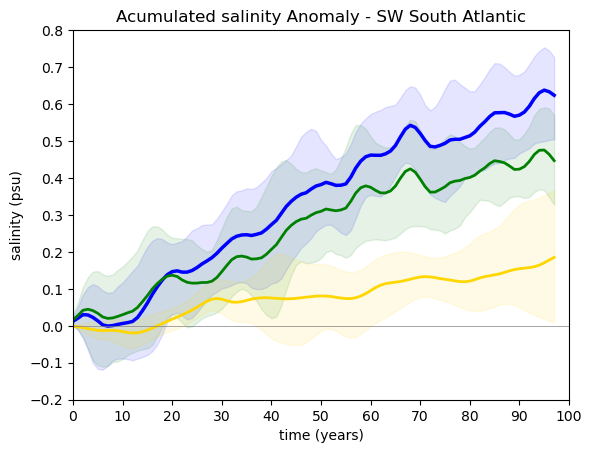

In [80]:
plt.plot(timey[:-2],movingaverage(movingaverage(st.mean(axis=1),4),4)[:-2],'b',linewidth = 2.5)

plt.plot(timey[:-2],movingaverage(movingaverage(ocean.mean(axis=1),4),4)[:-2],'g',linewidth = 2)

plt.plot(timey[:-2],movingaverage(movingaverage(surf.mean(axis=1),4),4)[:-2],'gold',linewidth = 2)

plt.fill_between(timey[:-2],movingaverage(movingaverage(st.min(axis=1),4),4)[:-2],
                movingaverage(movingaverage(st.max(axis=1),4),4)[:-2],color='b',alpha=0.1)

plt.fill_between(timey[:-2],movingaverage(movingaverage(ocean.min(axis=1),4),4)[:-2],
                movingaverage(movingaverage(ocean.max(axis=1),4),4)[:-2],color='g',alpha=0.1)

plt.fill_between(timey[:-2],movingaverage(movingaverage(surf.min(axis=1),4),4)[:-2],
                movingaverage(movingaverage(surf.max(axis=1),4),4)[:-2],color='gold',alpha=0.1)

plt.plot([0,100],[0,0],color='grey',linewidth = 0.5)
plt.xlim(0,100)
plt.yticks(np.arange(-0.2,0.9,0.1))
# plt.ylim(-0.6,2)
plt.xticks(np.arange(0,101,10))

plt.xlabel('time (years)')
plt.ylabel('salinity (psu)')

# plt.grid()
plt.title('Acumulated salinity Anomaly - SW South Atlantic')
# plt.legend(['Salinity tendency','Sum of oceanic fluxes','Sum of surface fluxes'])

In [81]:
a=((ocean[30:,:].mean(axis=0)-st[30:,:].mean(axis=0))*100)/st[30:,:].mean(axis=0)
print(a.mean())
print(a.min())
print(a.max())

-22.148153
-41.27563
-6.8519654


Text(0.5, 1.0, 'Acumulated salinity Anomaly - SW South Atlantic')

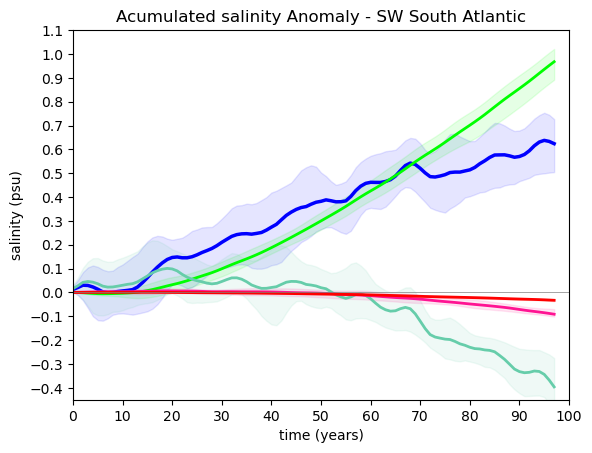

In [82]:
plt.plot(timey[:-2],movingaverage(movingaverage(st.mean(axis=1),4),4)[:-2],'b',linewidth = 2.5)

plt.plot(timey[:-2],movingaverage(movingaverage(hor_adv_conv.mean(axis=1),4),4)[:-2],'lime',linewidth = 2)

plt.plot(timey[:-2],movingaverage(movingaverage(hor_diff_conv.mean(axis=1),4),4)[:-2],'mediumaquamarine',linewidth = 2)

plt.plot(timey[:-2],movingaverage(movingaverage(vert_adv_conv.mean(axis=1),4),4)[:-2],'deeppink',linewidth = 2)

plt.plot(timey[:-2],movingaverage(movingaverage(vert_diff_conv.mean(axis=1),4),4)[:-2],'r',linewidth = 2)

plt.fill_between(timey[:-2],movingaverage(movingaverage(st.min(axis=1),4),4)[:-2],
                movingaverage(movingaverage(st.max(axis=1),4),4)[:-2],color='b',alpha=0.1)

plt.fill_between(timey[:-2],movingaverage(movingaverage(hor_adv_conv.min(axis=1),4),4)[:-2],
                movingaverage(movingaverage(hor_adv_conv.max(axis=1),4),4)[:-2],color='lime',alpha=0.1)

plt.fill_between(timey[:-2],movingaverage(movingaverage(hor_diff_conv.min(axis=1),4),4)[:-2],
                movingaverage(movingaverage(hor_diff_conv.max(axis=1),4),4)[:-2],color='mediumaquamarine',alpha=0.1)

plt.fill_between(timey[:-2],movingaverage(movingaverage(vert_adv_conv.min(axis=1),4),4)[:-2],
                movingaverage(movingaverage(vert_adv_conv.max(axis=1),4),4)[:-2],color='deeppink',alpha=0.1)

plt.fill_between(timey[:-2],movingaverage(movingaverage(vert_diff_conv.min(axis=1),4),4)[:-2],
                movingaverage(movingaverage(vert_diff_conv.max(axis=1),4),4)[:-2],color='r',alpha=0.1)

plt.plot([0,100],[0,0],color='grey',linewidth = 0.5)
plt.xlim(0,100)
plt.yticks(np.arange(-0.6,1.2,0.1))
plt.ylim(-0.45,1.1)
plt.xticks(np.arange(0,101,10))

plt.xlabel('time (years)')
plt.ylabel('salinity (psu)')

# plt.grid()
plt.title('Acumulated salinity Anomaly - SW South Atlantic')
# plt.legend(['Salinity tendency','Sum of oceanic fluxes','Sum of surface fluxes'])

In [ ]:
plt.plot(timey[:-2],movingaverage(movingaverage(st.mean(axis=1),4),4)[:-2],'b',linewidth = 2.5)

plt.plot(timey[:-2],movingaverage(movingaverage(surf.mean(axis=1),4),4)[:-2],'gold',linewidth = 2)

plt.plot(timey[:-2],movingaverage(movingaverage(evap.mean(axis=1),4),4)[:-2],'sienna',linewidth = 2)

plt.plot(timey[:-2],movingaverage(movingaverage(pr.mean(axis=1),4),4)[:-2],'darkblue',linewidth = 2)

plt.plot(timey[:-2],movingaverage(movingaverage(runoff.mean(axis=1),4),4)[:-2],'cyan',linewidth = 2)

plt.fill_between(timey[:-2],movingaverage(movingaverage(st.min(axis=1),4),4)[:-2],
                movingaverage(movingaverage(st.max(axis=1),4),4)[:-2],color='b',alpha=0.1)

plt.fill_between(timey[:-2],movingaverage(movingaverage(evap.min(axis=1),4),4)[:-2],
                movingaverage(movingaverage(evap.max(axis=1),4),4)[:-2],color='sienna',alpha=0.1)

plt.fill_between(timey[:-2],movingaverage(movingaverage(pr.min(axis=1),4),4)[:-2],
                movingaverage(movingaverage(pr.max(axis=1),4),4)[:-2],color='darkblue',alpha=0.1)

plt.fill_between(timey[:-2],movingaverage(movingaverage(runoff.min(axis=1),4),4)[:-2],
                movingaverage(movingaverage(runoff.max(axis=1),4),4)[:-2],color='cyan',alpha=0.1)

plt.fill_between(timey[:-2],movingaverage(movingaverage(surf.min(axis=1),4),4)[:-2],
                movingaverage(movingaverage(surf.max(axis=1),4),4)[:-2],color='gold',alpha=0.1)

plt.plot([0,100],[0,0],color='grey',linewidth = 0.5)
plt.xlim(0,100)
plt.yticks(np.arange(-0.6,0.9,0.1))
# plt.ylim(-0.6,2)
plt.xticks(np.arange(0,101,10))

plt.xlabel('time (years)')
plt.ylabel('salinity (psu)')

# plt.grid()
plt.title('Acumulated salinity Anomaly - SW South Atlantic')
# plt.legend(['Salinity tendency','Sum of oceanic fluxes','Sum of surface fluxes'])

Text(0.5, 1.0, 'Acumulated salinity Anomaly - SW South Atlantic')

In [7]:
## pme, melt, runoff --> (kg/m^3)*(m/sec)
s='pre-industrial'
var_name='sst'
d1=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+s+'/ocean/'+var_name+'*.nc'));d1=[d1[0]]
sstC=xr.open_dataset(d1[0])[var_name].sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean()

var_name='evap'
d1=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+s+'/ocean/'+var_name+'*.nc'));d1=[d1[0]]
evapC=xr.open_dataset(d1[0])[var_name].sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean()


In [5]:
sim = ['PI-FW04Gr-ic','PI-FW04Gr-ic-02','PI-FW04Gr-ic-03','PI-FW04Gr-ic-04']
var_name='sst'
var_name2='evap'
for i,s in enumerate(sim):
    z1=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+s+'/ocean/'+var_name+'*.nc'));z1=[z1[0]]
    z2=sorted(glob.glob('/g/data/y99/gp9664/access-esm/extracted/'+s+'/ocean/'+var_name2+'*.nc'));z2=[z2[0]]
    if i==0:
        sst=np.expand_dims(xr.open_dataset(z1[0])[var_name].sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean']).groupby('time.year').mean(['time']).values,1)
        evap=np.expand_dims(xr.open_dataset(z2[0])[var_name2].sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean']).groupby('time.year').mean(['time']).values,1)
    else:
        tmp=np.expand_dims(xr.open_dataset(z1[0])[var_name].sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean']).groupby('time.year').mean(['time']).values,1)
        sst = np.concatenate([sst,tmp],axis=1)

        tmp=np.expand_dims(xr.open_dataset(z2[0])[var_name2].sel(xt_ocean=slice(x1_sw,x2_sw),yt_ocean=slice(y1_sw,y2_sw)).mean(['xt_ocean','yt_ocean']).groupby('time.year').mean(['time']).values,1)
        evap = np.concatenate([evap,tmp],axis=1)


In [8]:
sst = sst - sstC.values
evap = evap - evapC.values

(0.0, 100.0)

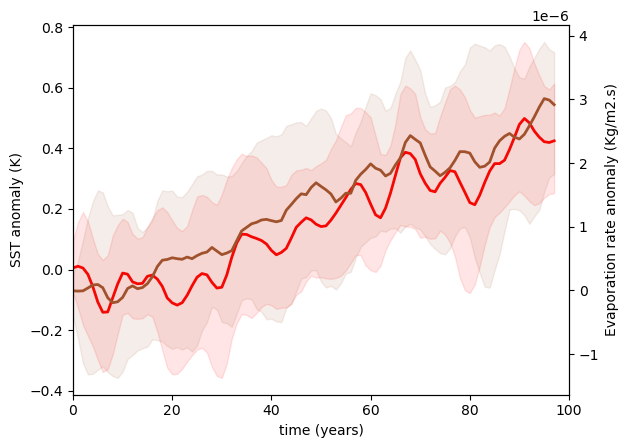

In [12]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

fig, host = plt.subplots()
plt.xlabel("time (years)")
ax2 = host.twinx()

host.set_ylabel("SST anomaly (K)")
ax2.set_ylabel("Evaporation rate anomaly (Kg/m2.s)")

p1, = host.plot(timey[:-2],movingaverage(movingaverage(sst.mean(axis=1),4),4)[:-2],'r',linewidth = 2)
host.fill_between(timey[:-2],movingaverage(movingaverage(sst.min(axis=1),4),4)[:-2],
                movingaverage(movingaverage(sst.max(axis=1),4),4)[:-2],color='r',alpha=0.1)
# host.legend(['SST'],loc=2)

p2, = ax2.plot(timey[:-2],movingaverage(movingaverage(-evap.mean(axis=1),4),4)[:-2],'-',color='sienna',linewidth = 2)
ax2.fill_between(timey[:-2],movingaverage(movingaverage(-evap.min(axis=1),4),4)[:-2],
                movingaverage(movingaverage(-evap.max(axis=1),4),4)[:-2],color='sienna',alpha=0.1)
# ax2.set_ylim(-500,100)
# plt.xticks(np.arange(1900,2080,10))
plt.xlim(0,100)
# ax2.legend(['Evap'],loc=4)


In [15]:
ens=['PI-FW04NA-01','PI-FW04NA-02','PI-FW04NA-03','PI-FW04NA-04']

In [16]:
sst=xr.DataArray(sst,[('year', timey),('ens', ens)])
sst.attrs['long_name']='Sea surface temperature anomaly'
sst.attrs['description']='averaged between 15S-35S and 60W-30W, 100-years average of reference simulation removed'
sst.attrs['units']='K'
sst.attrs['simulation']='PI-FW04Gr-ic'
sst.attrs['reference_simulation']='piControl'
sst.attrs['model']='ACCESS-ESM1-5'
sst.name='ssta'

In [20]:
evap=xr.DataArray(sst,[('year', timey),('ens', ens)])
evap.attrs['long_name']='Evaporation rate anomaly'
evap.attrs['description']='averaged between 15S-35S and 60W-30W, 100-years average of reference simulation removed'
evap.attrs['units']='Kg/m**2/s'
evap.attrs['simulation']='PI-FW04Gr-ic'
evap.attrs['reference_simulation']='piControl'
evap.attrs['model']='ACCESS-ESM1-5'
evap.name='evapa'

In [23]:
data = xr.merge([sst,evap])
del data.attrs['long_name']
del data.attrs['description']
del data.attrs['units']
del data.attrs['simulation']
del data.attrs['reference_simulation']
del data.attrs['model']

In [26]:
dir_out='/g/data/y99/gp9664/data_AMOC_NGEO/'
data.to_netcdf(dir_out+'FigEDh_sst_evap_swsa_ACCESS-ESM1-5_PI-FW04Gr-ic.nc','w')
